#Preprocessing Images

This notebook shows the preprocessing procedure for an image.  
The general steps are:  
1) load the image and pad the shorter side with black to make it square  
2) find the center and radius of the eye and trim a square to that size  
3) convert to grayscale and normalize the color range with contrast stretching  
4) resize the image to 64x64 and 128x128  
5) create 7 additional images for each size from rotations (90,180,270-deg) and flip and rotations (0,90,180,270-deg)  
  
**Note:** Visualizations are shown in notebook but not needed in preprocessing script

###Load libraries

In [202]:
%matplotlib inline

import matplotlib.pyplot as plt  # for visualizations

import numpy as np

from sklearn.metrics import classification_report

from PIL import Image
import PIL

from skimage.transform import resize
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray

from csv import DictReader
from collections import defaultdict

import cPickle


###Look at some 64x64 current preprocessed images

(5000, 64, 64)


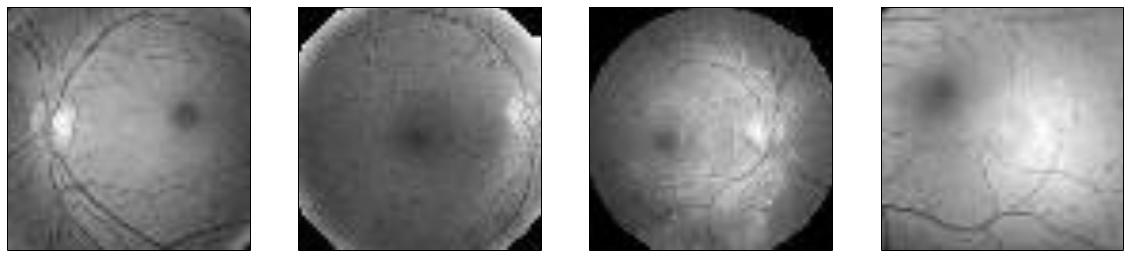

In [200]:
# load a sample of images
path = "images_graySample.cpickle"
f = open(path, 'r')
image_list = cPickle.load(f)
print np.array(image_list).shape

IMAGE_SIZE = 64

images = np.array(image_list)
images = images/255.0
images = np.reshape(np.array(images),(images.shape[0], IMAGE_SIZE**2))

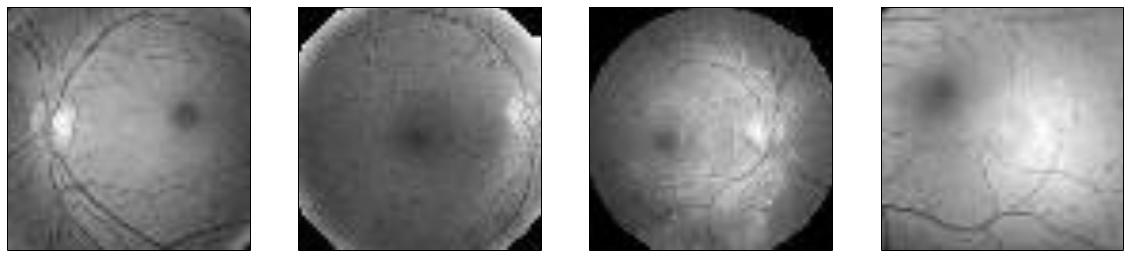

In [199]:
# look at the first few images
num_images = 4
f,p = plt.subplots(1,num_images, figsize=(20,5))
plt.rc('image', cmap='gray')
for i in range(num_images):
    p[i].imshow(np.reshape(images[i],(IMAGE_SIZE, IMAGE_SIZE)))
    plt.setp(p[i].get_xticklabels(), visible=False)
    plt.setp(p[i].get_xticklines(), visible=False)
    plt.setp(p[i].get_yticklabels(), visible=False)
    plt.setp(p[i].get_yticklines(), visible=False)


###Open a jpeg image

In [24]:
thirteenR = Image.open("13_right.jpeg")
tenL = Image.open("10_left.jpeg")
# look at image sizes
print np.asarray(thirteenR).shape
print np.asarray(tenL).shape

##Pad image with black to make square

height =  1944
width =  2592

original image shape =  (1944, 2592, 3)
shape of padding =  (324, 2592, 3)


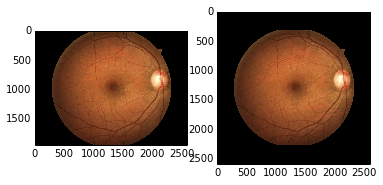

In [210]:
imagename = "13_right.jpeg"
im = Image.open(imagename)
im = np.asarray(im)

# get height and width of the image
ht =im.shape[0]
wd = im.shape[1]
print "height = ",ht
print "width = ",wd

# amount of padding needed to make a square image
paddingamt = int(np.absolute(wd-ht)/2.0)

# axis for concatenation
concataxis = 1*(wd<ht)
 
# make padding arrays
if concataxis==0:
    padding = np.zeros((paddingamt, im.shape[1], im.shape[2]))
else:
    padding = np.zeros((im.shape[0], paddingamt, im.shape[2]))

print "\noriginal image shape = ",im.shape
print "shape of padding = ",padding.shape

# concatenate to make padded image
paddedim = np.concatenate([padding, im, padding], axis=concataxis)

# show the images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
paddedim = np.asarray(Image.fromarray(util.img_as_ubyte(paddedim/255.0)))
axarr[1].imshow(paddedim)
    
    

### Make grayscale and make eye part of image white

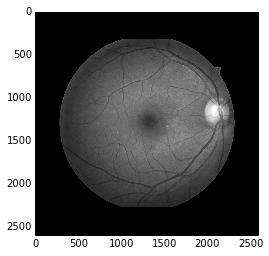

In [211]:
# convert to grayscale
paddedimgray = rgb2gray(paddedim)
plt.imshow(paddedimgray)


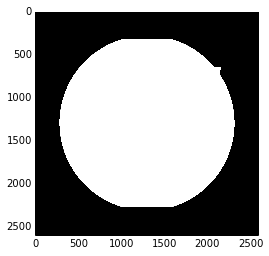

In [212]:
# make any part of the image that is not (very close to) black, white
whitened = np.zeros(paddedimgray.shape)
whitened[paddedimgray>0.1]=255
plt.imshow(whitened)

## Find center and radius of whitened eyeball

In [213]:
cntrrow = int(np.mean(np.where(whitened==255)[0]))
cntrcol = int(np.mean(np.where(whitened==255)[1]))

print("Center of white area at (%d, %d)" % (cntrrow, cntrcol))

d1 = np.max(np.where(whitened[cntrrow,:]==255))-np.min(np.where(whitened[cntrrow,:]==255))
d2 = np.max(np.where(whitened[:,cntrcol]==255))-np.min(np.where(whitened[:,cntrcol]==255))
radius = np.max([d1,d2])/2.0
print "radius = ",radius

Center of white area at (1295, 1296)
radius =  1013.0


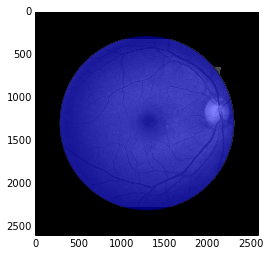

In [214]:
# Plot area identified as eye to verify (not part of preprocessing)
plt.rc('image', cmap='gray')
f, p = plt.subplots(1,1)
p.add_artist(plt.Circle((cntrcol, cntrrow), radius=radius, fc = 'b', alpha=0.5))
p.imshow(paddedimgray)

###Trim image to square centered around eye with side=diameter

2308.0 282.0
2309.0 283.0


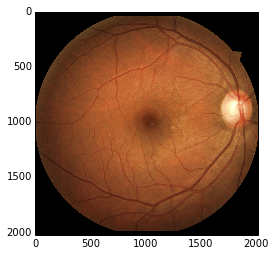

In [215]:
leftc = cntrcol-radius
rightc = cntrcol+radius
topr = cntrrow-radius
bottomr = cntrrow+radius
print top, bottom
print left, right

trimmedim = paddedim[topr:bottomr,leftc:rightc,:]
plt.imshow(trimmedim)

##These are a few different color normalizations
If we want color, then probably use the first one, otherwise, I think that the contrast stretching one looks best

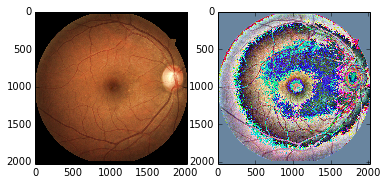

In [216]:
#Normalize each channel to zero mean, unit variance
#    (This is similar to what the 2nd place team did for their model)
norm = np.zeros(trimmedim.shape)
norm[:,:,0] = (trimmedim[:,:,0]-np.mean(trimmedim[:,:,0]))/np.std(trimmedim[:,:,0])
norm[:,:,1] = (trimmedim[:,:,1]-np.mean(trimmedim[:,:,1]))/np.std(trimmedim[:,:,1])
norm[:,:,2] = (trimmedim[:,:,2]-np.mean(trimmedim[:,:,2]))/np.std(trimmedim[:,:,2])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(trimmedim)
axarr[1].imshow(norm)

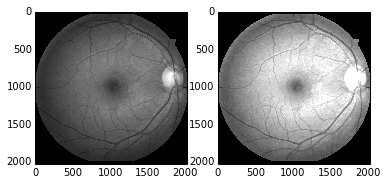

In [217]:
#Contrast stretching
from skimage import exposure

trimmedimgray = color.rgb2gray(trimmedim)
p2, p98 = np.percentile(trimmedimgray, (2, 98))

trimmedimgray_rescale = exposure.rescale_intensity(trimmedimgray, in_range=(p2, p98))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(trimmedimgray)
axarr[1].imshow(trimmedimgray_rescale)

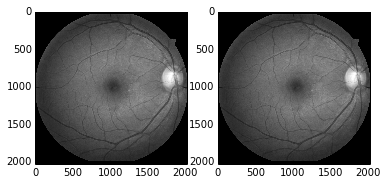

In [218]:
#Normalize grayscale image to zero mean and unit variance
normgray = (trimmedimgray-np.mean(trimmedimgray))/np.std(trimmedimgray)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(trimmedimgray)
axarr[1].imshow(normgray)

###Resize the image to 64x64 and 128x128

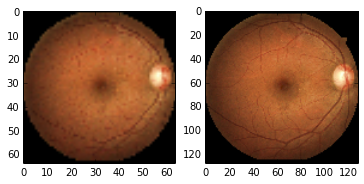

In [219]:
f, axarr = plt.subplots(1,2)

resized64im = resize(trimmedim, (64,64))
axarr[0].imshow(resized64im)

resized128im = resize(trimmedim, (128,128))
axarr[1].imshow(resized128im)


##Create rotations

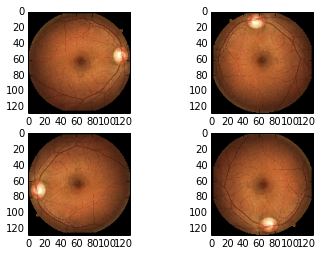

In [220]:
f, axarr = plt.subplots(2,2)

rotated90 = np.asarray(Image.fromarray(util.img_as_ubyte(resized128im)).rotate(90))
rotated180 = np.asarray(Image.fromarray(util.img_as_ubyte(resized128im)).rotate(180))
rotated270 = np.asarray(Image.fromarray(util.img_as_ubyte(resized128im)).rotate(270))


axarr[0,0].imshow(resized128im)
axarr[0,1].imshow(rotated90)
axarr[1,0].imshow(rotated180)
axarr[1,1].imshow(rotated270)


##Flip

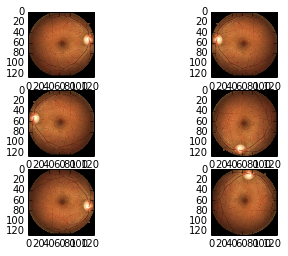

In [221]:
f, axarr = plt.subplots(3,2)

#mirror = np.fliplr(image_first)

flip = np.asarray(Image.fromarray(util.img_as_ubyte(resized128im)).transpose(PIL.Image.FLIP_LEFT_RIGHT))
axarr[0,0].imshow(resized128im)
axarr[0,1].imshow(flip)

flip90 = np.asarray(Image.fromarray(util.img_as_ubyte(flip)).rotate(90))
flip180 = np.asarray(Image.fromarray(util.img_as_ubyte(flip)).rotate(180))
flip270 = np.asarray(Image.fromarray(util.img_as_ubyte(flip)).rotate(270))

axarr[1,0].imshow(flip)
axarr[1,1].imshow(flip90)
axarr[2,0].imshow(flip180)
axarr[2,1].imshow(flip270)